# Testing hypotheses via a mixture estimation model

Simple demo of the idea in https://arxiv.org/pdf/1412.2044v2.pdf  
Related discussion: [Christian Robert's Blog post](https://xianblog.wordpress.com/2016/12/05/bayesian-parameter-estimation-versus-model-comparison/), [Discussion on X validated](https://xianblog.wordpress.com/2016/12/05/bayesian-parameter-estimation-versus-model-comparison/)  
The data and code is based on the [BEST example of PyMC3](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/BEST.ipynb)

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
# np.random.seed(20090425)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


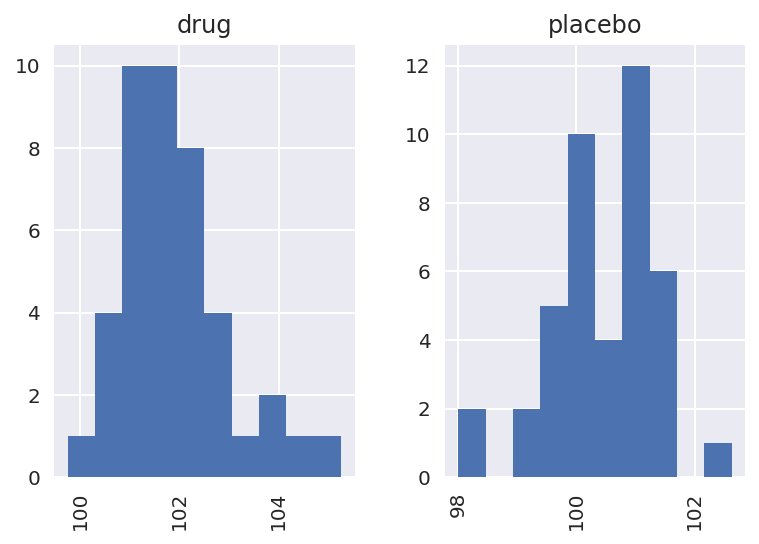

In [2]:
# drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
#         109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
#         96,103,124,101,101,100,101,101,104,100,101)
# placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
#            104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
#            101,100,99,101,100,102,99,100,99)

Nsbj = 42
drug    = np.random.normal(loc=101.8,scale=1,size=Nsbj)
placebo = np.random.normal(loc=100.5,scale=1,size=Nsbj)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

# Bayesian Estimation Supersedes the T-Test (BEST) model

In [3]:
with pm.Model() as model:
    μ1 = pm.Flat('μ1')
    σ1 = pm.HalfFlat('σ1')
    group1 = pm.Normal('drug', mu=μ1, sd=σ1, observed=y1)
    
    μ2 = pm.Flat('μ2')
    σ2 = pm.HalfFlat('σ2')
    group2 = pm.Normal('placebo', mu=μ2, sd=σ2, observed=y2)
    start = pm.find_MAP()
start

logp = -121.62, ||grad|| = 20.225: 100%|██████████| 69/69 [00:00<00:00, 2065.02it/s]          


{'μ1': array(101.9183096),
 'μ2': array(100.49399409),
 'σ1': array(1.07997276),
 'σ1_log__': array(0.07693582),
 'σ2': array(0.90155026),
 'σ2_log__': array(-0.10363949)}

In [4]:
# Bayesian Estimation Supersedes the T-Test (BEST) model
μ_m = y.value.mean()
μ_s = y.value.std() * 2
σ_low  = 0
σ_high = 10

with pm.Model() as model:
    μ1 = pm.Normal('μ1', μ_m, sd=μ_s)
    μ2 = pm.Normal('μ2', μ_m, sd=μ_s)
    
    σ1 = pm.Uniform('σ1', lower=σ_low, upper=σ_high)
    σ2 = pm.Uniform('σ2', lower=σ_low, upper=σ_high)
    
    group1 = pm.Normal('drug', mu=μ1, sd=σ1, observed=y1)
    group2 = pm.Normal('placebo', mu=μ2, sd=σ2, observed=y2)
    
    diff_of_means = pm.Deterministic('μ1-μ2', μ1 - μ2)
    diff_of_stds = pm.Deterministic('σ1-σ2', σ1 - σ2)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((σ1**2 + σ2**2) / 2))
    
    trace = pm.sample(1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ2_interval__, σ1_interval__, μ2, μ1]
100%|██████████| 1500/1500 [00:01<00:00, 869.75it/s]


In [5]:
pltvar = ['μ1', 'μ2', 'σ1', 'σ2']
maplist = [float(start[val]) for val in pltvar]
maplist

[101.9183095995307, 100.49399408589437, 1.0799727608742922, 0.901550255172812]

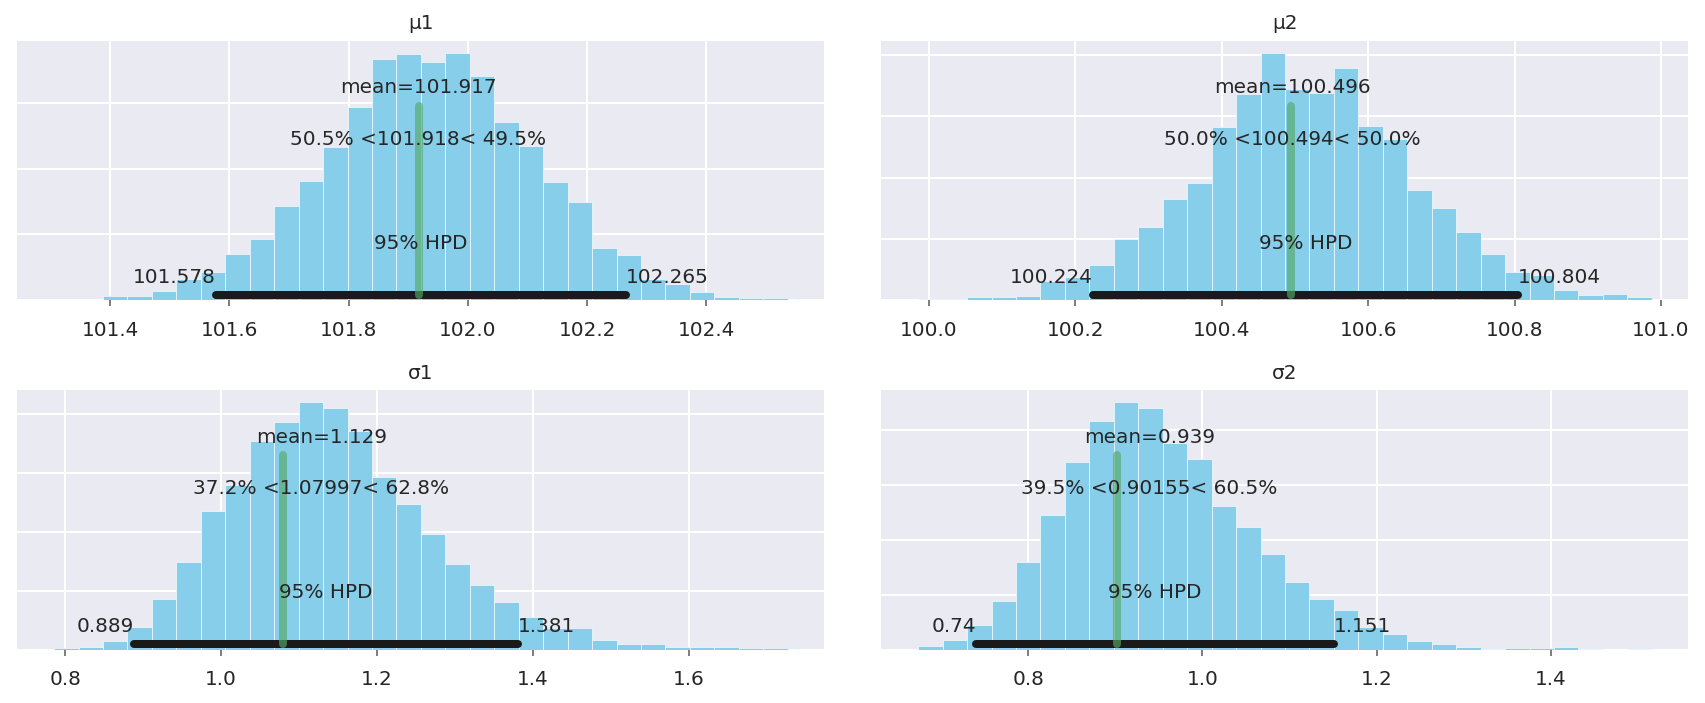

In [6]:
pltvar = ['μ1', 'μ2', 'σ1', 'σ2']
pm.plot_posterior(trace, 
                  varnames=pltvar,
                  ref_val=maplist,
                  color='#87ceeb');

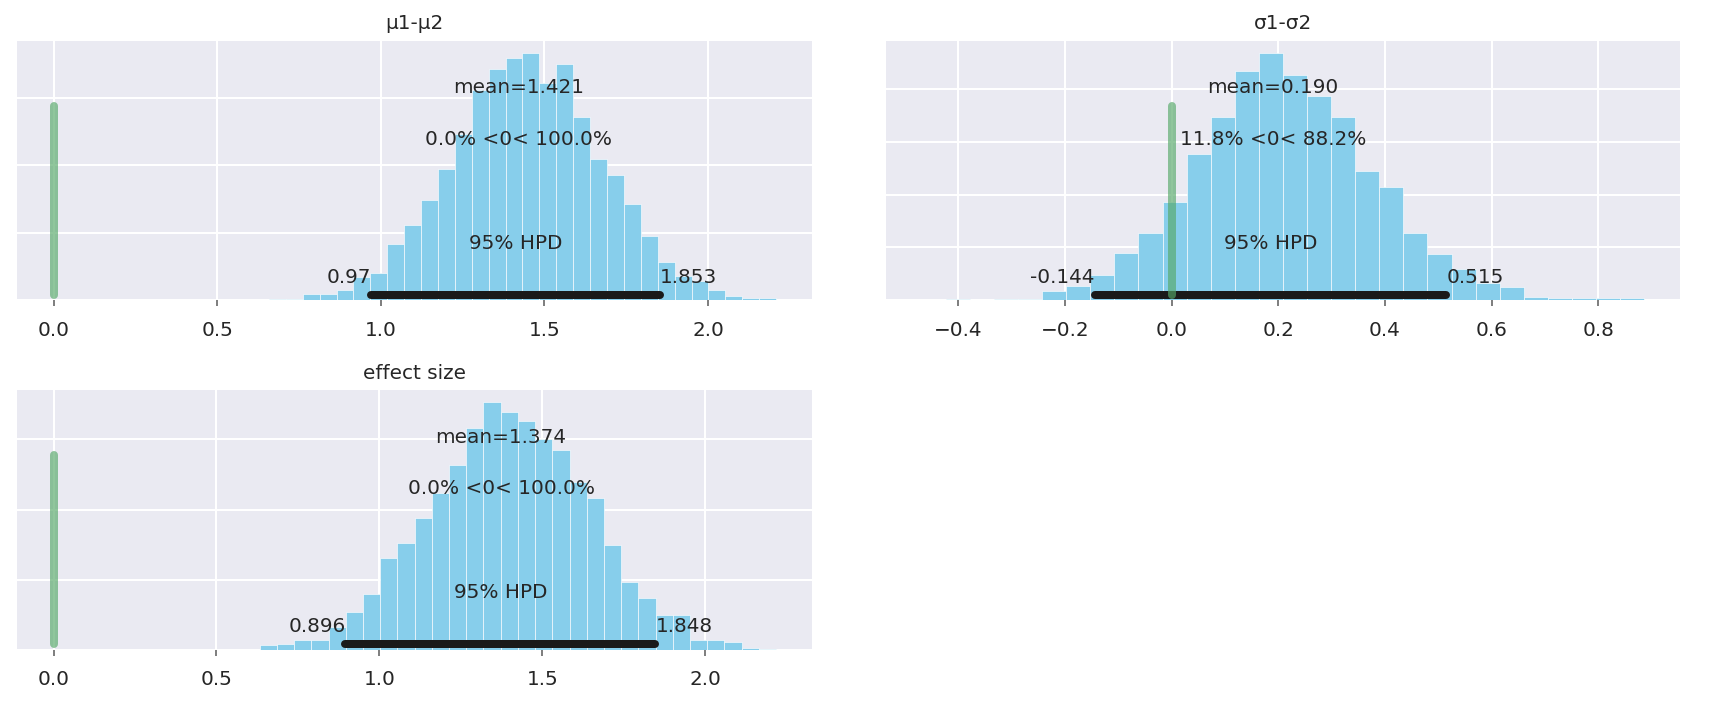

In [7]:
pm.plot_posterior(trace, 
                  varnames=['μ1-μ2', 'σ1-σ2', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

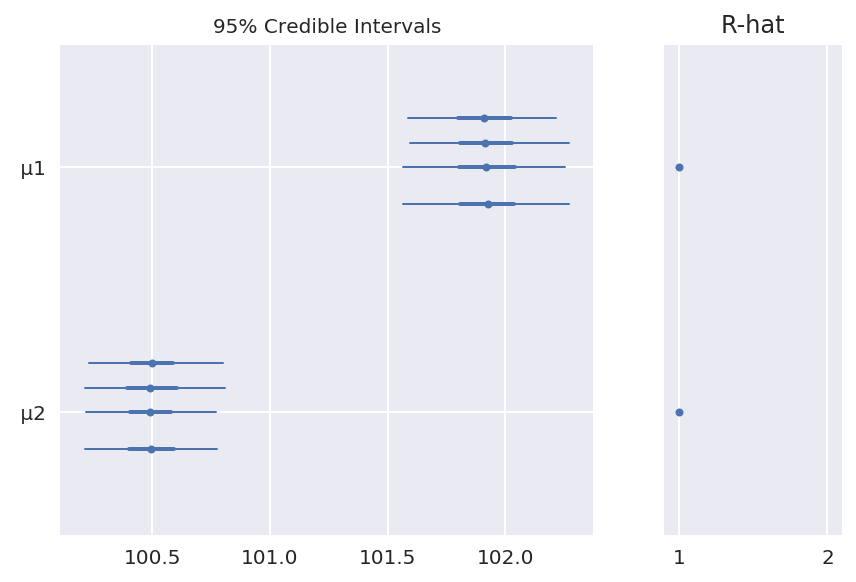

In [8]:
pm.forestplot(trace, varnames=[v.name for v in model.vars[:2]])

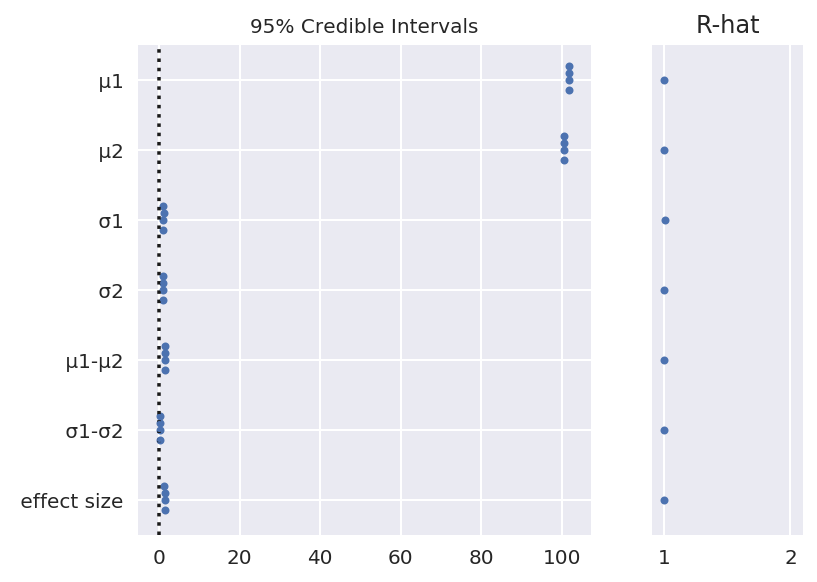

In [11]:
pm.forestplot(trace, varnames=['μ1', 'μ2', 'σ1', 'σ2',
                               'μ1-μ2', 'σ1-σ2', 'effect size']);

In [12]:
pm.df_summary(trace, 
              varnames=['μ1-μ2', 'σ1-σ2', 'effect size'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: df_summary has been deprecated. In future, use summary instead.
  


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ1-μ2,1.420712,0.225773,0.002872,0.970291,1.853411,4000.0,0.999852
σ1-σ2,0.189702,0.167486,0.002458,-0.143996,0.515484,4000.0,1.000043
effect size,1.373794,0.244395,0.003456,0.896071,1.847602,4000.0,0.999886


# Testing hypotheses via a mixture estimation model

In the Kamary et al (2014) they introduced a  novel  paradigm  for  Bayesian  testing  of  hypotheses and Bayesian model comparison. Their alternative to the traditional  construction  of  Bayes  factors  or  posterior probabilities  of  a model  given  the  data  is  to  consider  the  hypotheses  or  models  under
comparison as components of a mixture model. Therefore, the original testing problem is replaced with an estimation one that focuses on the probability or weight of a given hypothesis within the mixture model.

A reference $\text{Beta}(a_0,a_0)$ prior on the mixture weights can be used for the common problem of
testing two contrasting hypotheses or models. In this case the sensitivity of the posterior estimates of the weights to the choice of $a_0$ vanishes as the sample size increases. Kamary et al advocate a default choice of $a_0 = 0.5$, derived from Rousseau and Mengersen (2011)

### Update 2017-03-20
Sort the mixture weight so to break the multimodality [ref](http://mc-stan.org/documentation/case-studies/identifying_mixture_models.html). However, one must be careful of placing the order of the mixture component, as the less possible component should be place in the front. As a heuristic we can place the component coding for the null hypothesis before the alternative hypothesis, as our strawman null hypothesis is mostly false. Of course, if the null hypothesis is actually more plausible this approach will backfired.

In [ ]:
# Hypotheses testing via mixture model estimation
import theano.tensor as tt
from pymc3.math import logsumexp
# from pymc3.dist_math import logpow, gammaln

with pm.Model() as model2:
    #H0
    group0_mean = pm.Normal('group0_mean', μ_m, sd=μ_s)
    group0_std = pm.Uniform('group0_std', lower=σ_low, upper=σ_high)
    
    group1_h0 = pm.Normal('drug_h0',    mu=group0_mean, sd=group0_std)
    group2_h0 = pm.Normal('placebo_h0', mu=group0_mean, sd=group0_std)
    
    #H1
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)
    
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
    
    group1_h1 = pm.Normal('drug_h1', mu=group1_mean, sd=group1_std)
    group2_h1 = pm.Normal('placebo_h1', mu=group2_mean, sd=group2_std)
    
    a0 = pm.Dirichlet('a0', a=np.ones((2))*.5)
    # use sort to break multimodality
    a = pm.Deterministic('mixing',tt.sort(a0))
    
    group1 = pm.Mixture('drug',    w=a, comp_dists=[group1_h0.distribution,group1_h1.distribution], observed=y1)
    group2 = pm.Mixture('placebo', w=a, comp_dists=[group2_h0.distribution,group2_h1.distribution], observed=y2)
    
#     a = pm.Beta('mixing',alpha=.5,beta=.5)
#     def mixturelogp(w,dist1,dist2):
#         logp1 = dist1.distribution.logp
#         logp2 = dist2.distribution.logp
#         def logp_(value):
#             logps = tt.log(w) + logp1(value) + tt.log(1-w) + logp2(value)
#             return tt.sum(logsumexp(logps))
#         return logp_
#     group1 = pm.DensityDist('drug',    mixturelogp(a,group1_h0,group1_h1), observed=y1)
#     group2 = pm.DensityDist('placebo', mixturelogp(a,group2_h0,group2_h1), observed=y2)

    #start = pm.find_MAP()
    trace = pm.sample(2000, njobs=4, tune=2000)

In [ ]:
pm.traceplot(trace,
             varnames=['mixing', 
                      'group0_mean', 'group0_std',
                      'group1_mean', 'group2_mean', 'group1_std', 'group2_std'])
plt.show()

In [ ]:
accept = trace.get_sampler_stats('mean_tree_accept', burn=burnin)
print('The accept rate is: %.5f' % (accept.mean()))
diverge = trace.get_sampler_stats('diverging',burn=burnin)
print('Effective samples')
print(pm.diagnostics.effective_n(trace))
print('Diverge of the trace')
print(diverge.nonzero())
energy = trace['energy']
energy_diff = np.diff(energy)
sns.distplot(energy - energy.mean(), label='energy')
sns.distplot(energy_diff, label='energy diff')
plt.legend()
plt.show()

In [ ]:
pm.plot_posterior(trace, 
                  varnames=['mixing', 
                            'group0_mean', 'group0_std',
                            'group1_mean', 'group2_mean', 'group1_std', 'group2_std'],
                  color='#87ceeb');

Note that, the mixture model is not very well parameterized (in more ambiguous situation the estimation could be off badly). A better parameterization or other MC sampling techinque should be used for any real problem.

# Model selection via Bayes Factor

In [ ]:
with pm.Model() as model3:
    delta = pm.Cauchy('delta', alpha=0, beta=1)
    group_mean = pm.Normal('group_mean', μ_m, sd=μ_s)
    
    group_std = pm.Uniform('group_std', lower=σ_low, upper=σ_high)
    alpha = delta*group_std
    
    group1 = pm.Normal('drug', mu=group_mean+alpha/2, sd=group_std, observed=y1)
    group2 = pm.Normal('placebo', mu=group_mean-alpha/2, sd=group_std, observed=y2)
    
    trace3 = pm.sample(2000, njobs=2, tune=1000)
    
pm.plot_posterior(trace3[1000:], 
                  varnames=['group_mean', 'group_std', 'delta'],
                  color='#87ceeb');

In [ ]:
def display_delta(trace, x):
    # BFs based on density estimation (using kernel smoothing instead of spline)
    from scipy.stats.kde import gaussian_kde
    from scipy.stats import cauchy

    pm.summary(trace, varnames=['delta'])
    tmp = pm.df_summary(trace, varnames=['delta'])
    # 95% confidence interval:
    x0 = tmp.values[0, 3]
    x1 = tmp.values[0, 4]

    t_delt = trace['delta'][:]
    my_pdf = gaussian_kde(t_delt)
    plt.plot(x, my_pdf(x), '--', lw=2.5, alpha=0.6, label='Posterior') # distribution function
    plt.plot(x, cauchy.pdf(x), 'r-', lw=2.5, alpha=0.6, label='Prior')
    posterior = my_pdf(0)             # this gives the pdf at point delta = 0
    prior     = cauchy.pdf(0)         # height of order-restricted prior at delta = 0
    BF01      = posterior/prior
    print ('the Bayes Factor is %.5f' %(BF01))
    plt.plot([0, 0], [posterior, prior], 'k-', 
             [0, 0], [posterior, prior], 'ko', lw=1.5, alpha=1)
    plt.xlabel('Delta')
    plt.ylabel('Density')
    plt.legend(loc='upper left')
    plt.show()
    
x = np.linspace(-3, 3, 100)
display_delta(trace3[1000:], x)